[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  Image Augmentation

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 02/06/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0095DeepLearningImageAugmentation.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning

# Deep Learning
import torch
import torch.nn            as nn
from torch.utils.tensorboard import SummaryWriter
import torchinfo
import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Image Processing & Computer Vision
import skimage as ski

# Miscellaneous
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Any, Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('../../utils')
from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import NNMode
from DeepLearningPyTorch import RunEpoch


In [6]:
# General Auxiliary Functions

def PlotTransform( lImages: List[torchvision.tv_tensors._image.Image], titleStr: str, bAxis = False ) -> plt.Figure:
    
    numImg = len(lImages)
    axWidh = 3
    
    lWidth  = [lImages[ii].shape[-1] for ii in range(numImg)]
    hF, _ = plt.subplots(nrows = 1, ncols = numImg, figsize = (numImg * axWidh, 5), gridspec_kw = {'width_ratios': lWidth})
    for ii, hA in enumerate(hF.axes):
        mI = torch.permute(lImages[ii], (1, 2, 0))
        hA.imshow(mI, cmap = 'gray')
        hA.set_title(f'{ii}')
        hA.axis('on') if bAxis else hA.axis('off')
    
    hF.suptitle(titleStr)
    
    return hF


def PlotBeta( α: float ) -> None:
    
    vX = np.linspace(0, 1, 1001)
    vP = sp.stats.beta.pdf(vX, α, α)

    hF, hA = plt.subplots(figsize = (8, 6))


    hA.plot (vX, vP, 'b', lw=2)
    hA.set_title(f'Beta($\\alpha={α:0.3f}$, $\\beta={α:0.3f}$)')
    hA.set_ylim([0, 5])
    hA.grid();
    # hF.show()

def PlotAug( λ: Union[float, torch.Tensor], mI1: np.ndarray, mI2: np.ndarray, augStr: str, λVal: float ) -> None:
    mI = λ * mI1 + (1 - λ) * mI2 #<! Supports λ as a mask
    hF, vHa = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 5))

    hA = vHa[0]
    hA.imshow(mI.permute(1, 2, 0))
    hA.set_title(f'{augStr} ($\\lambda = {λVal:0.3f}$)')

    hA = vHa[1]
    hA.stem([0, 1], [λVal, 1 - λVal])
    hA.set_title(f'{augStr} Label ($\\lambda = {λVal:0.3f}$)')
    hA.set_xlabel('Class')
    hA.set_ylabel('Probability')
    hA.set_ylim([0, 1.05])


## Image Augmentation - CutOut, MixUp, CutMix

Several _image augmentation techniques_ have been developed to farther assist the generalization of the models.  
Some of the techniques involves manipulation of 2 images and the labels.

 - CutOut  
   Randomly removes a segment (Rectangle) of the image.  
   One may think of it as a "Dropout" layer on the input.  
   See [Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552).
 - MixUp  
   Alpha channel like mix of 2 images.  
   It also mixes the labels.  
   See [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412).
 - CutMix  
   Mixes cut of the images without blending.
   It also mixes the labels.  
   See [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899).

<!-- ![](https://i.imgur.com/Bapq0uB.png)   -->
<img src="https://i.imgur.com/Bapq0uB.png" width="600"/></br>
**Credit**: [Leonie Monigatti - Cutout, Mixup, and Cutmix: Implementing Modern Image Augmentations in PyTorch](https://towardsdatascience.com/cutout-mixup-and-cutmix-implementing-modern-image-augmentations-in-pytorch-a9d7db3074ad).

This notebooks presents:

 * Working `torchvision.transforms` module.
 * Applying: `CutOut`, `MixUp`, `CutMix`.


This notebook augments both the image data and the labels.

</br>

* <font color='brown'>(**#**)</font> PyTorch Tutorial: [How to Use CutMix and MixUp](https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html).
* <font color='brown'>(**#**)</font> Augmentation can be thought as the set of operation the model should be insensitive to.  
  For instance, if it should be insensitive to shift, the same image should be trained on with different shifts.
* <font color='brown'>(**#**)</font> PyTorch Vision is migrating its transforms module from `v1` to `v2`.  
  This notebook will focus on `v2`.
* <font color='brown'>(**#**)</font> While the notebook shows image augmentation in the context of Deep Learning for Computer Vision, the [_Data Augmentation_](https://en.wikipedia.org/wiki/Data_augmentation) concept can be utilized for other tasks as well.  
  For instance, for _Audio Processing_ on could apply some noise addition, pitch change, filters, etc...
* <font color='brown'>(**#**)</font> The are packages which specialize on image data augmentation: [Kornia](https://github.com/kornia/kornia), [Albumentations](https://github.com/albumentations-team/albumentations) (Considered to be the [fastest](https://github.com/albumentations-team/albumentations#benchmarking-results)), [ImgAug](https://github.com/aleju/imgaug) (Deprecated), [AugLy](https://github.com/facebookresearch/AugLy) (Audio, image, text and video).

In [7]:
# Parameters

# Data
imgFile1Url = r'https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/09_TipsAndTricks/img1.jpg'
imgFile2Url = r'https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/09_TipsAndTricks/img2.jpg'

img1Label = 0
img2Label = 1

# Model

# Training

# Visualization


## Generate / Load Data



In [8]:
# Load Data

mI1 = ski.io.imread(imgFile1Url)

# Image Dimensions
print(f'Image Dimensions: {mI1.shape[:2]}')
print(f'Image Number of Channels: {mI1.shape[2]}')
print(f'Image Element Type: {mI1.dtype}')

Image Dimensions: (450, 300)
Image Number of Channels: 3
Image Element Type: uint8


In [9]:
# Load Data

mI2 = ski.io.imread(imgFile2Url)

# Image Dimensions
print(f'Image Dimensions: {mI2.shape[:2]}')
print(f'Image Number of Channels: {mI2.shape[2]}')
print(f'Image Element Type: {mI2.dtype}')

Image Dimensions: (183, 275)
Image Number of Channels: 3
Image Element Type: uint8


* <font color='brown'>(**#**)</font> The image is a _NumPy_ array. PyTorch default image loader is using [`PIL`](https://github.com/python-pillow/Pillow) (Pillow, as its optimized version) where the image is the PIL class.

### Plot the Data

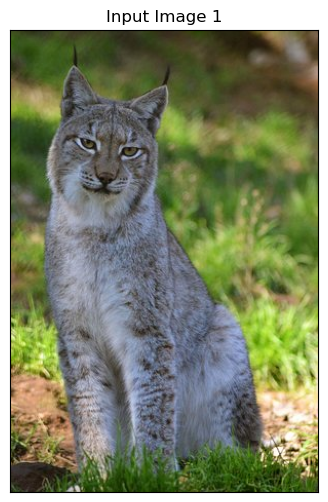

In [10]:
# Plot the Data

hF, hA = plt.subplots(figsize = (4, 6))

hA.imshow(mI1)
hA.tick_params(axis = 'both', left = False, top = False, right = False, bottom = False, 
               labelleft = False, labeltop = False, labelright = False, labelbottom = False)
hA.grid(False)
hA.set_title('Input Image 1');


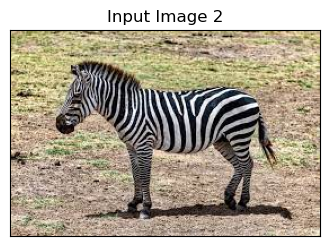

In [11]:
# Plot the Data

hF, hA = plt.subplots(figsize = (4, 6))

hA.imshow(mI2)
hA.tick_params(axis = 'both', left = False, top = False, right = False, bottom = False, 
               labelleft = False, labeltop = False, labelright = False, labelbottom = False)
hA.grid(False)
hA.set_title('Input Image 2');

In [12]:
# Tensor Image (Scaled)

oToImg = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(dtype = torch.float32, scale = True),
])

tI1 = oToImg(mI1)
tI2 = oToImg(mI2)

print(f'Tensor Type: {type(tI1)}')
print(f'Tensor Dimensions: {tI1.shape}')
print(f'Image Element Type: {tI1.dtype}')
print(f'Image Minimum Value: {torch.min(tI1)}')
print(f'Image Maximum Value: {torch.max(tI1)}')

Tensor Type: <class 'torchvision.tv_tensors._image.Image'>
Tensor Dimensions: torch.Size([3, 450, 300])
Image Element Type: torch.float32
Image Minimum Value: 0.0
Image Maximum Value: 1.0


## Cut Out (Random Erasing)

Randomly erases a rectangle on the image.  
Assists with regularization of the model with the intuition it works like a "Dropout" layer on the input.

* <font color='brown'>(**#**)</font> [Random Erasing Data Augmentation](https://arxiv.org/abs/1708.04896) ([Source Code](https://github.com/zhunzhong07/Random-Erasing)).
* <font color='brown'>(**#**)</font> [Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552).
* <font color='brown'>(**#**)</font> When using `value = 'random'` on float tensor it generates Gaussian Noise.



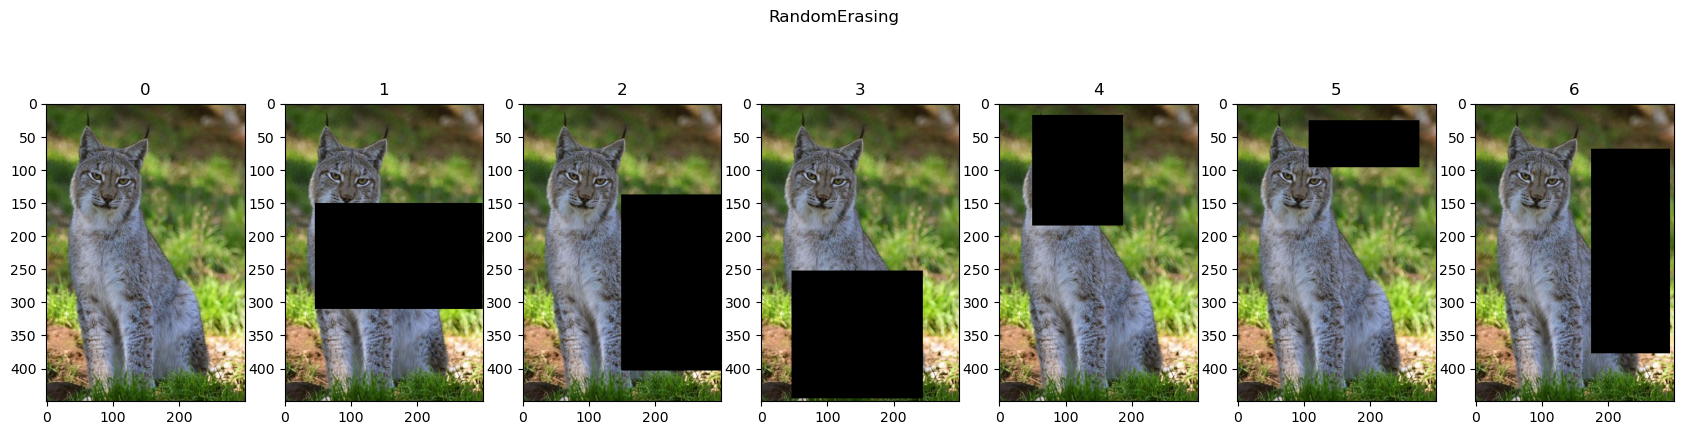

In [13]:
# RandomErasing
oTran = TorchVisionTrns.RandomErasing(p = 1, value = 0)

lTrnImg = [tI1] + [oTran(tI1) for _ in range(6)]
hF = PlotTransform(lTrnImg, 'RandomErasing', True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


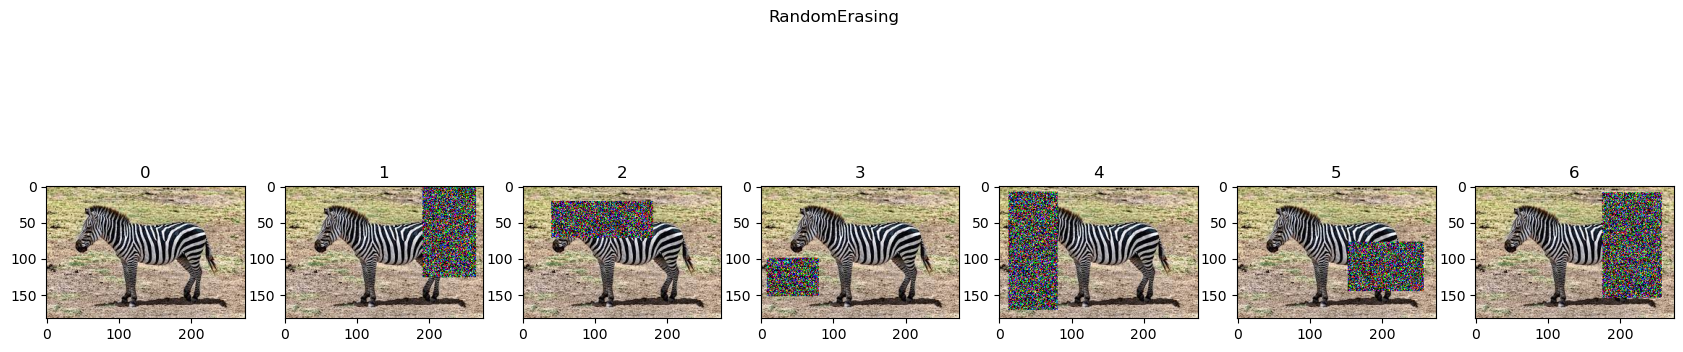

In [14]:
# RandomErasing
oTran = TorchVisionTrns.RandomErasing(p = 1, value = 'random')

lTrnImg = [tI2] + [oTran(tI2) for _ in range(6)]
hF = PlotTransform(lTrnImg, 'RandomErasing', True)

## MixUp

Samples a parameter $\lambda$ from a [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution):

$$ \lambda \sim \text{Beta} \left( \alpha, \alpha \right), \qquad \alpha \in \left[ 0, 1 \right]$$

Using the parameter the image and label is adjusted:

$$
\begin{align*}
\hat{\boldsymbol{x}} & = \lambda \boldsymbol{x}_{i} + \left( 1 - \lambda \right) \boldsymbol{x}_{j} \\
\hat{\boldsymbol{y}} & = \lambda \boldsymbol{y}_{i} + \left( 1 - \lambda \right) \boldsymbol{y}_{j} \\
\end{align*}
$$

Where $\boldsymbol{x}_{i}, \boldsymbol{x}_{j}$ are 2 input vectors and $\boldsymbol{y}_{i}, \boldsymbol{y}_{j}$ are 2 _one hot_ label encoding.

* <font color='brown'>(**#**)</font> [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412).
* <font color='brown'>(**#**)</font> Requires change in the training loop or data loader.



### Beta Distribution

In [15]:
# Beta Distribution

interact(PlotBeta, α = FloatSlider(min = 0.01, max = 0.99, step = 0.01, value = 0.5, layout = Layout(width = '30%')));

interactive(children=(FloatSlider(value=0.5, description='α', layout=Layout(width='30%'), max=0.99, min=0.01, …

* <font color='brown'>(**#**)</font> For $\alpha \to 0$ the distribution becomes to a _Bernoulli Distribution_.
* <font color='brown'>(**#**)</font> For $\alpha \to 1$ the distribution becomes $\mathcal{U} \left[ 0 , 1 \right]$.
* <font color='brown'>(**#**)</font> Usually $\alpha$ is chosen to make the value of $\lambda$ be $0$ or $1$ most probable. Hence $\alpha$ is relatively small most of the time.

In [16]:
# MixUp
oTran = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(dtype = torch.float32, scale = True),
    TorchVisionTrns.Resize(224),
    TorchVisionTrns.CenterCrop(224),
])

tI1 = oTran(mI1)
tI2 = oTran(mI2)

hPlotMixUp = lambda λ: PlotAug(λ, tI1, tI2, 'MixUp', λ)

interact(hPlotMixUp, λ = FloatSlider(min = 0.0, max = 1.0, step = 0.05, value = 0.0, layout = Layout(width = '30%')));

interactive(children=(FloatSlider(value=0.0, description='λ', layout=Layout(width='30%'), max=1.0, step=0.05),…

## CutMix

Samples a parameter $\lambda$ from a [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution):

$$ \lambda \sim \text{Beta} \left( \alpha, \alpha \right), \qquad \alpha \in \left[ 0, 1 \right]$$

Using the parameter the image and label is adjusted:

$$
\begin{align*}
\hat{\boldsymbol{X}} & = \boldsymbol{M} \boldsymbol{X}_{i} + \left( \boldsymbol{1} \boldsymbol{1}^{T} - \boldsymbol{M} \right) \boldsymbol{X}_{j} \\
\hat{\boldsymbol{y}} & = \lambda \boldsymbol{y}_{i} + \left( 1 - \lambda \right) \boldsymbol{y}_{j} \\
\end{align*}
$$

Where $\boldsymbol{X}_{i}, \boldsymbol{X}_{j}$ are 2 input images of size $H \times W$ and $\boldsymbol{y}_{i}, \boldsymbol{y}_{j}$ are 2 _one hot_ label encoding.  
The data mask, $\boldsymbol{M}$, is built by the bounding box $\boldsymbol{b} = {\left[ x, y, w, h \right]}^{T}$:

$$
x \sim \mathcal{U} \left[ 0, W \right], y \sim \mathcal{U} \left[ 0, H \right], w = \sqrt{1 - \lambda} W, h = \sqrt{1 - \lambda} H
$$


* <font color='brown'>(**#**)</font> Some clipping might be needed to impose a valid bounding box.
* <font color='brown'>(**#**)</font> [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899).
* <font color='brown'>(**#**)</font> Requires change in the training loop or data loader.



In [17]:
# Generate Random Box

def RandBox( imgW: int, imgH: int, λ: float ) -> Tuple[int, int, int, int]:
    # λ: Proportional to the rectangle size

    xCenter = np.random.randint(imgW)
    yCenter = np.random.randint(imgH)
    
    ratio = np.sqrt (1 - λ)
    w     = np.int32(imgW * ratio)
    h     = np.int32(imgH * ratio)

    xLow  = np.maximum(xCenter - w // 2, 0)
    yLow  = np.maximum(yCenter - h // 2, 0)
    xHigh = np.minimum(xCenter + w // 2, imgW)
    yHigh = np.minimum(yCenter + h // 2, imgH)

    return xLow, yLow, xHigh, yHigh

* <font color='brown'>(**#**)</font> In practice, if the rectangle gets clipped one must rescale $\lambda$ accordingly.

In [18]:
# Generate Mask

def GenMask( imgW: int, imgH: int, λ: float ) -> torch.Tensor:

    mM = torch.ones((imgH, imgW))
    xLow, yLow, xHigh, yHigh = RandBox(imgW, imgH, λ)

    mM[yLow:yHigh, xLow:xHigh] = 0.0

    return mM

In [19]:
# CutMix

hPlotMixUp = lambda λ: PlotAug(torch.permute(GenMask(224, 224, λ)[:, :, None], (2, 1, 0)), tI1, tI2, 'CutMix', λ)

interact(hPlotMixUp, λ = FloatSlider(min = 0.0, max = 1.0, step = 0.05, value = 0.0, layout = Layout(width = '30%')));

interactive(children=(FloatSlider(value=0.0, description='λ', layout=Layout(width='30%'), max=1.0, step=0.05),…